In [124]:
from __future__ import unicode_literals, print_function, division
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from cn_cn_data import get_cn_en_dataloader, to_sentence, cn_vocab, en_vocab


In [125]:
from get_cn_en_pairs import get_training_pairs, SOS_token, EOS_token, MAX_LENGTH, output_lang, input_lang, tensorFromSentence

In [126]:
max_length = MAX_LENGTH
device = torch.device("cpu")

In [127]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [128]:
seq_len = 15
# max_length = seq_len + 2
batch_size = 1

cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)

device = torch.device("cpu")
train_loader, train_dataset = get_cn_en_dataloader(seq_len, batch_size, device)
print('length of train_loader', len(train_loader))

length of train_loader 2207


In [129]:
for i, item in enumerate(train_loader):
    print(item[0].shape, item[1].shape)

    print([idx.item() for idx in item[0]])
    print(to_sentence(item[0], True))
    print([idx.item() for idx in item[1]])
    print(to_sentence(item[1], False))
    break

torch.Size([13, 1]) torch.Size([10, 1])
[2, 19, 963, 58, 153, 905, 131, 172, 10, 823, 956, 5, 3]
['<sos>', '我', '总', '是', '忘', '记', '别', '人', '的', '名', '字', ' 。', '<eos>']
[2, 12, 27, 1096, 4730, 606, 71, 2150, 5, 3]
['<sos>', 'I', "'m", 'always', 'forgetting', 'people', "'s", 'names', '.', '<eos>']


In [130]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        outputs, hidden = self.gru(embedded, hidden)

        return outputs, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


In [131]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [132]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden #

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [133]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = get_training_pairs(n_iters)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [134]:
hidden_size = 256
encoder1 = Encoder(input_lang.n_words, hidden_size).to(device)
decoder1 = Decoder(hidden_size, output_lang.n_words).to(device)

In [135]:
train_losses = trainIters(encoder1, decoder1, 50000, print_every=500)

0m 8s (- 13m 39s) (500 1%) 3.5679
0m 16s (- 13m 18s) (1000 2%) 3.3655
0m 24s (- 13m 5s) (1500 3%) 3.3548
0m 32s (- 12m 48s) (2000 4%) 3.2312
0m 39s (- 12m 34s) (2500 5%) 3.2002
0m 47s (- 12m 26s) (3000 6%) 3.0115
0m 55s (- 12m 20s) (3500 7%) 2.9781
1m 3s (- 12m 9s) (4000 8%) 2.9435
1m 11s (- 11m 59s) (4500 9%) 2.8775
1m 18s (- 11m 50s) (5000 10%) 2.7816
1m 27s (- 11m 46s) (5500 11%) 2.7503
1m 35s (- 11m 37s) (6000 12%) 2.6921
1m 42s (- 11m 28s) (6500 13%) 2.5141
1m 50s (- 11m 20s) (7000 14%) 2.5550
1m 58s (- 11m 11s) (7500 15%) 2.4069
2m 6s (- 11m 2s) (8000 16%) 2.3378
2m 14s (- 10m 54s) (8500 17%) 2.2719
2m 21s (- 10m 46s) (9000 18%) 2.2277
2m 29s (- 10m 38s) (9500 19%) 2.2141
2m 37s (- 10m 30s) (10000 20%) 2.1279
2m 45s (- 10m 22s) (10500 21%) 2.0997
2m 53s (- 10m 14s) (11000 22%) 2.0762
3m 1s (- 10m 6s) (11500 23%) 1.9936
3m 9s (- 9m 58s) (12000 24%) 1.8709
3m 16s (- 9m 50s) (12500 25%) 1.7703
3m 24s (- 9m 42s) (13000 26%) 1.7418
3m 32s (- 9m 34s) (13500 27%) 1.7064
3m 40s (- 9m 26s

<Figure size 640x480 with 0 Axes>

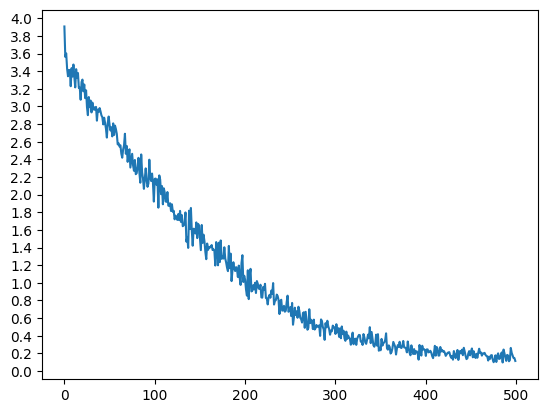

In [136]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [137]:
encoder_path = './models/seq2seq6-encoder.pt'
decoder_path = './models/seq2seq6-decoder.pt'


In [138]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)


In [139]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = train_dataset.tokenize_sentence(sentence, True).unsqueeze(0).T
        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei])
            encoder_outputs[ei] = encoder_output[0][0]

        decoder_input = torch.tensor([SOS_token], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, input_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            # decoder_attentions[di] = decoder_attention.squeeze().data
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_vocab.lookup_token(topi.item()))

            decoder_input = topi.squeeze(1).detach()

        return decoded_words


In [140]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [141]:
encoder2 = Encoder(input_lang.n_words, hidden_size).to(device)
decoder2 = Decoder(hidden_size, output_lang.n_words).to(device)

encoder2.load_state_dict(torch.load(encoder_path))
decoder2.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

In [142]:
evaluateRandomly(encoder1, decoder1)


> 他们不理我。
= They're ignoring me.


TypeError: forward() missing 1 required positional argument: 'hidden'

In [ ]:
output_words = evaluate(encoder1, decoder1, "我不确定。")
output_sentence = ' '.join(output_words)
print(output_sentence)


In [ ]:
# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions.numpy(), cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + list(input_sentence) +
#                        ['<EOS>'], rotation=90)
#     ax.set_yticklabels([''] + output_words)

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()


# def evaluateAndShowAttention(input_sentence):
#     output_words, attentions = evaluate(encoder2, decoder2, input_sentence)
#     print('input =', input_sentence)
#     print('output =', ' '.join(output_words))
#     showAttention(input_sentence, output_words, attentions)


# evaluateAndShowAttention("我不确定。")


- encode hidden is new in each forward? YES
- batch-first? YES
- NLLLOSS? NO
- data loader? NO